In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
data1 = pd.read_csv(r'C:\Users\s611863\Downloads\archive\FinalDatasetCsv.csv')
data1.head()

,Acc X,Acc Y,Acc Z,gyro_x,gyro_y,gyro_z,label
0,0.046402,-0.137178,-0.282934,-0.036306,-0.008226,-0.023416,0
1,-0.136978,0.365242,0.108889,0.035776,-0.009448,0.009570,0
2,-0.045355,-0.103340,-0.534985,-0.011871,-0.027774,0.003462,0
3,0.242089,0.072761,-0.350396,-0.017980,0.002769,-0.005091,0
4,-0.230234,0.011765,-0.494085,0.011342,0.003380,0.006516,0


In [9]:
X = np.array(data1.drop(['label'], axis=1))
y = np.array(data1['label'])

In [10]:
X

array([[ 0.04640213, -0.13717842, -0.28293374, -0.03630576, -0.00822632,
        -0.0234165 ],
       [-0.13697833,  0.365242  ,  0.10888884,  0.03577634, -0.00944805,
         0.00957022],
       [-0.04535493, -0.10334015, -0.5349848 , -0.01187115, -0.02777401,
         0.00346157],
       ...,
       [-0.4364062 , -0.21926403,  0.3979577 , -0.00160861,  0.02490294,
         0.000876  ],
       [-0.4364062 , -0.21926403,  0.3979577 , -0.00160861,  0.02490294,
         0.000876  ],
       [-0.4364062 , -0.21926403,  0.3979577 , -0.00160861,  0.02490294,
         0.000876  ]])

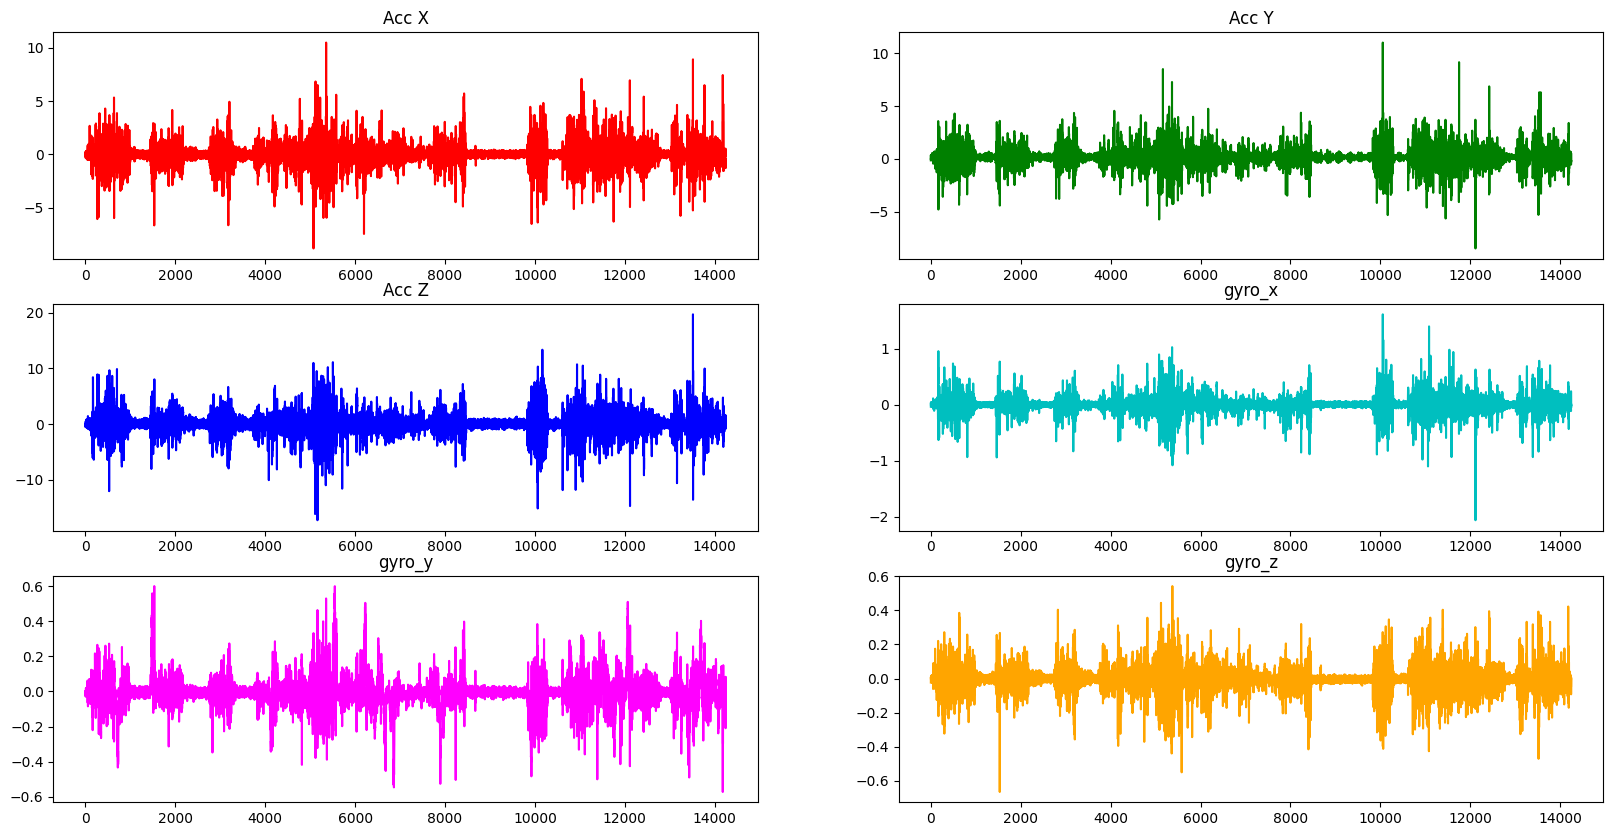

In [11]:
def plot_series(data, df_final_col_names):
    colors = ['r', 'g', 'b', 'c', 'magenta', 'orange', 'black']


    fig, axes = plt.subplots(data.shape[1] // 2, 2, figsize=(20, 10))

    try:
        for i in range(data.shape[1] // 2):
            for j in range (2):
                n = i * 2 + j

                axes[i][j].plot(np.arange(len(data[:, n])),data[:,n], color=colors[n])
                axes[i][j].set_title(df_final_col_names[n])
    except IndexError:
        print('Error!')

plot_series(X, data1.columns)

In [12]:
_window_size = 100
_batch_size = 64
_shuffle_buffer = 60800

In [13]:
ds = tf.concat([X, tf.expand_dims(tf.cast(y, 'float32'), -1)], axis=1)
ds

<tf.Tensor: shape=(14249, 7), dtype=float32, numpy=
array([[ 4.64021266e-02, -1.37178421e-01, -2.82933742e-01, ...,
        -8.22631828e-03, -2.34165005e-02,  0.00000000e+00],
       [-1.36978328e-01,  3.65242004e-01,  1.08888835e-01, ...,
        -9.44804959e-03,  9.57022235e-03,  0.00000000e+00],
       [-4.53549325e-02, -1.03340149e-01, -5.34984827e-01, ...,
        -2.77740061e-02,  3.46157001e-03,  0.00000000e+00],
       ...,
       [-4.36406195e-01, -2.19264030e-01,  3.97957712e-01, ...,
         2.49029398e-02,  8.75999976e-04,  1.00000000e+00],
       [-4.36406195e-01, -2.19264030e-01,  3.97957712e-01, ...,
         2.49029398e-02,  8.75999976e-04,  1.00000000e+00],
       [-4.36406195e-01, -2.19264030e-01,  3.97957712e-01, ...,
         2.49029398e-02,  8.75999976e-04,  1.00000000e+00]], dtype=float32)>

In [14]:
def windowed_dataset(ds, batch_size, shuffle_buffer, window_size):

    train_split_index = int(ds.shape[0] * 0.8)

    ds = tf.data.Dataset.from_tensor_slices(ds)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:, :-1], tf.cond(tf.reduce_sum(w[:, -1]) <  5, lambda : tf.constant([0]),
                                              lambda : tf.constant([1]))))


    ds = ds.shuffle(shuffle_buffer)


    train_ds, eval_ds = ds.take(train_split_index), ds.skip(train_split_index)


    train_ds, eval_ds = train_ds.batch(batch_size), eval_ds.batch(batch_size)

    return train_ds.prefetch(1), eval_ds.prefetch(1)


train_ds, eval_ds = windowed_dataset(ds, _batch_size, _shuffle_buffer, _window_size)
train_ds, eval_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>)

In [15]:
from tensorflow.keras import layers

In [16]:
def build_model():

    inputs = layers.Input(shape=(_window_size, 6))
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='HAR')

    return model

model = build_model()

In [17]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=METRICS)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    verbose=1,
    patience=4,
    mode='min',
    restore_best_weights=True)

In [27]:
history = model.fit(train_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10


179/179 [==============================] - 41s 162ms/step - loss: 0.3070 - tp: 6735.0000 - fp: 1049.0000 - tn: 3062.0000 - fn: 553.0000 - accuracy: 0.8595 - precision: 0.8652 - recall: 0.9241 - auc: 0.9376 - prc: 0.9613
Epoch 2/10
179/179 [==============================] - 28s 144ms/step - loss: 0.2152 - tp: 6798.0000 - fp: 323.0000 - tn: 3757.0000 - fn: 521.0000 - accuracy: 0.9260 - precision: 0.9546 - recall: 0.9288 - auc: 0.9626 - prc: 0.9751
Epoch 3/10
179/179 [==============================] - 27s 138ms/step - loss: 0.2246 - tp: 6836.0000 - fp: 486.0000 - tn: 3605.0000 - fn: 472.0000 - accuracy: 0.9160 - precision: 0.9336 - recall: 0.9354 - auc: 0.9645 - prc: 0.9765
Epoch 4/10
179/179 [==============================] - 28s 147ms/step - loss: 0.2434 - tp: 6949.0000 - fp: 691.0000 - tn: 3366.0000 - fn: 393.0000 - accuracy: 0.9049 - precision: 0.9096 - recall: 0.9465 - auc: 0.9569 - prc: 0.9697
Epoch 5/10
179/179 [==============================] - 27s 138ms/step - loss: 0.2020 - tp: 

In [28]:
model.save('New_Model.h5')

C:\Python-3.9.9\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model.evaluate(eval_ds)

43/43 [==============================] - 8s 57ms/step - loss: 0.1250 - tp: 1720.0000 - fp: 18.0000 - tn: 925.0000 - fn: 88.0000 - accuracy: 0.9615 - precision: 0.9896 - recall: 0.9513 - auc: 0.9842 - prc: 0.9891


[0.12504185736179352,
 1720.0,
 18.0,
 925.0,
 88.0,
 0.9614685773849487,
 0.9896432757377625,
 0.9513274431228638,
 0.9841604828834534,
 0.9890838265419006]

In [40]:
model.summary()

Model: "HAR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 bidirectional (Bidirection  (None, 100, 64)           9984      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 64)           24832     
 onal)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224    

In [40]:
loaded_model = tf.keras.models.load_model('New_Model.h5')

In [41]:
new_data = np.array([[-3.6770275,	1.3274183,	6.142731,	0.13962343,	0.092566445,	-0.16208291

]])




In [42]:
new_data_sequence = np.repeat(new_data, 100, axis=0)    

In [43]:
new_data_sequence = np.reshape(new_data_sequence, (1, 100, 6))

In [44]:
predictions = model.predict(new_data_sequence)

1/1 [==============================] - 0s 35ms/step


In [45]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [46]:
predictions

array([[0.98405576]], dtype=float32)

In [47]:
print("Predictions:", binary_predictions)

Predictions: [[1]]


In [36]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights('model_weights.h5')